In [56]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler
import pandas as pd
import random
import numpy as np
import timeit
from gorlib import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [57]:
#load data
dfs = load_file("./data/data.xlsx")
print("Available sheets:", dfs.keys())
for key in dfs:
    if "Date" in dfs[key].columns:
        dfs[key]['Date'] = pd.to_datetime(dfs[key]['Date'])

Available sheets: dict_keys(['Forecasted Consumption', 'Meter List', 'Rates'])


## Results 

In [58]:
#Answer to Question-1
res = calc_costs(dfs['Forecasted Consumption'], dfs['Rates'], dfs['Meter List'], "2020-10-01", "2022-09-30")
print(res)

     Meter ID  Total Estimated Consumption (kWh)  Total Cost (Pounds)
0  1000000603                           24656.07                 8.26
1    10588707                          122376.66                28.48
2    10626610                          303294.62                88.16


In [59]:
#Steps 2 and 3
randmeters = gen_rand_meters(dfs['Rates'], mcnt=100)
randconsm  = gen_mock_consn(randmeters["Meter ID"].tolist(),"2020-10-01", "2022-09-30")

In [60]:
#Testing on new generated data
res = calc_costs(randconsm, dfs['Rates'],randmeters, "2020-10-01", "2022-09-30")
print(res.head(10))

   Meter ID  Total Estimated Consumption (kWh)  Total Cost (Pounds)
0      1036                          111975.94                32.41
1      1027                          109606.75                36.88
2      1073                          110768.99                33.20
3      1038                          113276.30                33.50
4      1003                          112188.55                38.49
5      1001                          107572.60                31.66
6      1053                          113455.81                38.34
7      1040                          112422.79                33.08
8      1052                          108948.13                32.65
9      1020                          112029.53                32.97


# Profiling

In [61]:
randmeters = gen_rand_meters(dfs['Rates'], mcnt=100)
randconsm  = gen_mock_consn(randmeters["Meter ID"].tolist(),"2020-10-01", "2022-09-30")
permtr_cnt = randconsm.shape[0]/100.0

## Trying simple execution-time profiling

In [62]:
%%timeit
res = calc_costs(randconsm, dfs['Rates'],randmeters, "2020-10-01", "2022-09-30")

1 loop, best of 5: 684 ms per loop


In [63]:
randmeters = gen_rand_meters(dfs['Rates'], mcnt=1000)
randconsm  = gen_mock_consn(randmeters["Meter ID"].tolist(),"2020-10-01", "2022-09-30")

In [64]:
%%timeit
res = calc_costs(randconsm, dfs['Rates'],randmeters, "2020-10-01", "2022-09-30")

1 loop, best of 5: 11 s per loop


## Automated execution-time profiling for variable input length

In [65]:
imports = '''
from gorlib import calc_costs, gen_rand_meters, gen_mock_consn, load_file
import pandas as pd
dfs = load_file("./data/data.xlsx")
for key in dfs:
    if "Date" in dfs[key].columns:
        dfs[key]['Date'] = pd.to_datetime(dfs[key]['Date'])
randmeters = gen_rand_meters(dfs['Rates'], mcnt={mcnt})
randconsm  = gen_mock_consn(randmeters["Meter ID"].tolist(),"2020-10-01", "2022-09-30")
'''
testcode= '''
calc_costs(randconsm, dfs['Rates'],randmeters, "2020-10-01", "2022-09-30")
'''

cntlist = [10,50,100,500,1000,2000]
pftime = [timeit.timeit(stmt=testcode, setup=imports.format(mcnt=cnt), number=10)/10.0 for cnt in cntlist]

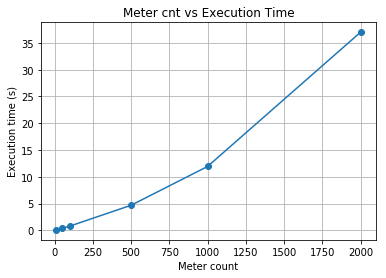

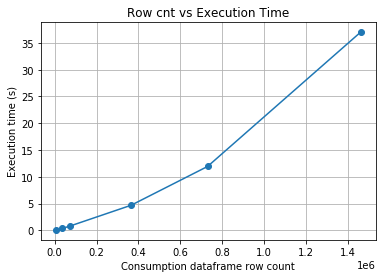

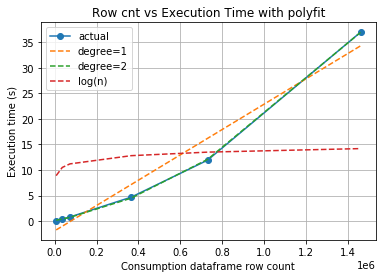

In [66]:
import matplotlib.pyplot as plt
import numpy.polynomial.polynomial as poly
plt.figure()
plt.plot(cntlist,pftime, marker="o")
plt.xlabel("Meter count")
plt.ylabel("Execution time (s)")
plt.title("Meter cnt vs Execution Time")
plt.grid()

plt.figure()
plt.plot(np.array(cntlist)*permtr_cnt,pftime, marker="o")
plt.xlabel("Consumption dataframe row count")
plt.ylabel("Execution time (s)")
plt.title("Row cnt vs Execution Time")
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.grid()

plt.figure()
rcnt = np.array(cntlist)*permtr_cnt
plt.plot(rcnt,pftime, marker="o", label="actual")
p1coefs = poly.polyfit(rcnt, pftime, 1)
ffit = poly.polyval(rcnt, p1coefs)
plt.plot(rcnt, ffit,"--", label="degree=1")
p2coefs = poly.polyfit(rcnt, pftime, 2)
ffit = poly.polyval(rcnt, p2coefs)
plt.plot(rcnt, ffit,"--", label="degree=2")
plt.plot(rcnt, np.log(rcnt),"--", label="log(n)")
plt.legend()
plt.xlabel("Consumption dataframe row count")
plt.ylabel("Execution time (s)")
plt.title("Row cnt vs Execution Time with polyfit")
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.grid()
plt.show()

### It can be noticed that the execution-time is not linear with the meter count/consumption df row count. The points fit degree 2 curves. Code line profiling is performed below to understand  potential bottlenecks.

In [67]:
%lprun -f calc_meter_cost calc_costs(randconsm, dfs['Rates'], randmeters, "2020-10-01", "2022-09-30")

Timer unit: 1e-06 s

Total time: 18.674 s
File: /home/radhika/dev/consumption_analysis/gorlib.py
Function: calc_meter_cost at line 17

Line #      Hits         Time  Per Hit   % Time  Line Contents
    17                                           def calc_meter_cost(forecast, rates, mid, ezone, aq, sdate, edate):
    18                                               """
    19                                               Calculates the total cost and consumption for a single meter
    20                                               """
    21      1000    7103036.0   7103.0     38.0      fdsel = (forecast["Meter ID"]== mid) & (forecast["Date"] >= sdate) & (forecast["Date"] < edate)
    22      1000    1487308.0   1487.3      8.0      rsel = (rates['Exit Zone'] == ezone) & (rates['Annual Quantity (Min)'] <= aq) & (rates['Annual Quantity (Max)'] > aq)
    23      1000     871628.0    871.6      4.7      dff = forecast.loc[fdsel]
    24      1000     947790.0    947.8      5.1      dff =

### The multi-conditional on line 21 seems to take a good percentage of the time. The actual multiplication is written as vectorized operation (Line 31).

In [68]:
%%timeit
res = calc_costs_opt(randconsm, dfs['Rates'], randmeters, "2020-10-01", "2022-09-30")

1 loop, best of 5: 12.5 s per loop


In [69]:
%lprun -f calc_meter_cost_opt calc_costs_opt(randconsm, dfs['Rates'], randmeters, "2020-10-01", "2022-09-30")

Timer unit: 1e-06 s

Total time: 18.4111 s
File: /home/radhika/dev/consumption_analysis/gorlib.py
Function: calc_meter_cost_opt at line 35

Line #      Hits         Time  Per Hit   % Time  Line Contents
    35                                           def calc_meter_cost_opt(forecast, rates, mid, ezone, aq, sdate, edate):
    36                                               """
    37                                               Same as calc_meter_cost: Used for testing optimization
    38                                               """
    39      1000    7082057.0   7082.1     38.5      fdsel = (forecast["Meter ID"]== mid) & (forecast["Date"] >= sdate) & (forecast["Date"] < edate)
    40      1000    1458363.0   1458.4      7.9      rsel = (rates['Exit Zone'] == ezone) & (rates['Annual Quantity (Min)'] <= aq) & (rates['Annual Quantity (Max)'] > aq)
    41      1000     867614.0    867.6      4.7      dff = forecast.loc[fdsel]
    42      1000     929700.0    929.7      5.0      df

# Todos
Some additional todos if time permits
1. Try numexpr for conditionals (some good results seen on stackoverflow)
2. See whether there could be precalculated dataframes that can be used over loops (for example rsel (Line 21))
3. Do memory profiling
4. Better code comments (e.g: Function parameter explanations)